In [22]:
# Natural Language Processing (NLP) Libraries
import nltk
import spacy
from spacy.lang.pt.examples import sentences
from gensim.utils import simple_preprocess

# Machine Learning Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import HDBSCAN
import torch
from torch import nn

# Transformers Library
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import DistilBertTokenizerFast, BertForTokenClassification, XLMRobertaForTokenClassification
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

# Text Processing Libraries
import re
from unidecode import unidecode

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Topic Modeling Libraries
from bertopic import BERTopic
from bertopic.representation import PartOfSpeech, KeyBERTInspired
from bertopic.cluster import BaseCluster
from umap import UMAP
from hdbscan import HDBSCAN

In [23]:
df_b2w = pd.read_csv("B2W-Reviews.csv")

C:\Users\isabe\AppData\Local\Temp\ipykernel_26588\316322153.py:1: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



In [24]:
df_b2w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   submission_date        132373 non-null  object 
 1   reviewer_id            132373 non-null  object 
 2   product_id             132373 non-null  object 
 3   product_name           132289 non-null  object 
 4   product_brand          40982 non-null   object 
 5   site_category_lv1      132367 non-null  object 
 6   site_category_lv2      128360 non-null  object 
 7   review_title           132071 non-null  object 
 8   overall_rating         132373 non-null  int64  
 9   recommend_to_a_friend  132355 non-null  object 
 10  review_text            129098 non-null  object 
 11  reviewer_birth_year    126389 non-null  float64
 12  reviewer_gender        128237 non-null  object 
 13  reviewer_state         128382 non-null  object 
dtypes: float64(1), int64(1), object(12)


In [25]:
most_frequent_product_name = df_b2w['product_name'].value_counts().idxmax()
product_df = df_b2w.loc[df_b2w['product_name'] == most_frequent_product_name]

In [65]:
most_frequent_product_name

'Smartphone Motorola Moto G 5S Dual Chip Android 7.1.1 Nougat Tela 5.2" Snapdragon 430 32GB 4G Câmera 16MP - Platinum'

In [26]:
product_df.head(3)

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
7,2018-01-01 01:58:17,e039cbff059effe12756772b358af4323c2157e9561da8...,132444092,Smartphone Motorola Moto G 5S Dual Chip Androi...,NaN,Celulares e Smartphones,Smartphone,Gostei bastante do produto,4,Yes,Produto excelente qualidade boa câmera desenvo...,1987.0,M,GO
147,2018-01-01 07:22:09,adb9eb06276a8cef5603f1da8c2c2ba1ad808f44a9e66e...,132444092,Smartphone Motorola Moto G 5S Dual Chip Androi...,NaN,Celulares e Smartphones,Smartphone,Muito show,5,Yes,"Produto excelente, ótimas funções, rápido, vis...",1989.0,M,CE
159,2018-01-01 07:36:13,b892f76c0d680293c529c89d7b52cbe5ce81d4a28e1956...,132444092,Smartphone Motorola Moto G 5S Dual Chip Androi...,NaN,Celulares e Smartphones,Smartphone,"Muito bom, câmera ótima",4,Yes,"Nada mal, tempo de entrega antes do prazo. Sob...",1995.0,M,SP


In [27]:
columns_to_drop = ['submission_date', 'reviewer_id', 'product_id', 'site_category_lv1', 'site_category_lv2', 'overall_rating', 'product_brand']
df = product_df.drop(columns=columns_to_drop)
df = df.reset_index(drop=True)

df.rename(columns={'review_text': 'comments'}, inplace=True)

In [28]:
df['comments'] = df['comments'].astype(str)

In [29]:
df.head()

,product_name,review_title,recommend_to_a_friend,comments,reviewer_birth_year,reviewer_gender,reviewer_state
0,Smartphone Motorola Moto G 5S Dual Chip Androi...,Gostei bastante do produto,Yes,Produto excelente qualidade boa câmera desenvo...,1987.0,M,GO
1,Smartphone Motorola Moto G 5S Dual Chip Androi...,Muito show,Yes,"Produto excelente, ótimas funções, rápido, vis...",1989.0,M,CE
2,Smartphone Motorola Moto G 5S Dual Chip Androi...,"Muito bom, câmera ótima",Yes,"Nada mal, tempo de entrega antes do prazo. Sob...",1995.0,M,SP
3,Smartphone Motorola Moto G 5S Dual Chip Androi...,Excelente!!!,Yes,"Excelente produto, belo design, fácil de manus...",1966.0,F,PR
4,Smartphone Motorola Moto G 5S Dual Chip Androi...,Problema com o aparelho,No,"Boa tarde. Estou insatisfeita com o aparelho, ...",1995.0,F,SP


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_name           792 non-null    object 
 1   review_title           790 non-null    object 
 2   recommend_to_a_friend  792 non-null    object 
 3   comments               792 non-null    object 
 4   reviewer_birth_year    758 non-null    float64
 5   reviewer_gender        775 non-null    object 
 6   reviewer_state         775 non-null    object 
 7   comments_topic         792 non-null    object 
 8   comments_entity        792 non-null    object 
dtypes: float64(1), object(8)
memory usage: 55.8+ KB


In [30]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [31]:
nltk.download(["stopwords", "rslp"])

PT_STOPWORDS = nltk.corpus.stopwords.words('portuguese')

REGEX = [
    {'input': r'/\d+/g', 'output': r' '},               # removing digits
    {'input': r'[^\w\s]', 'output': r' '},              # removing punctuationon
    {'input': r'\n', 'output': r' '},                   # removing line breaks
    {'input': r'\b\w{1,2}\b', 'output': r''},           # removing short words (1 or 2 characters)
]

def regex_treatment(text):
    for pattern in REGEX:
        text = re.sub(pattern['input'], pattern['output'], text)
    return text.strip().lower()

def remove_stopwords(text):
    words = simple_preprocess(text)
    phrase_adjusted = " ".join([word for word in words if word not in PT_STOPWORDS])
    return phrase_adjusted.lower()

spacy_lemma = spacy.load("pt_core_news_md")

# Ignoring VERBs, ADVs, ADJs, PROPNs (...)
def lemmatizer(text, postags_permit=['NOUN']):
    """https://spacy.io/api/annotation"""
    doc = spacy_lemma(text.lower())
    doc_lemma = " ".join([token.lemma_ for token in doc if token.pos_ in postags_permit])
    return doc_lemma

def remove_accentuation(text):
    return unidecode(text)

def remove_accentuation_lower(text):
    return unidecode(text.lower())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [32]:
df["comments_topic"] = df["comments"].apply(regex_treatment)
df["comments_topic"] = df["comments_topic"].apply(remove_stopwords)
df["comments_topic"] = df["comments_topic"].apply(lemmatizer)
df["comments_topic"] = df["comments_topic"].apply(remove_accentuation_lower)

In [33]:
df["comments_entity"] = df["comments"].apply(remove_accentuation_lower)

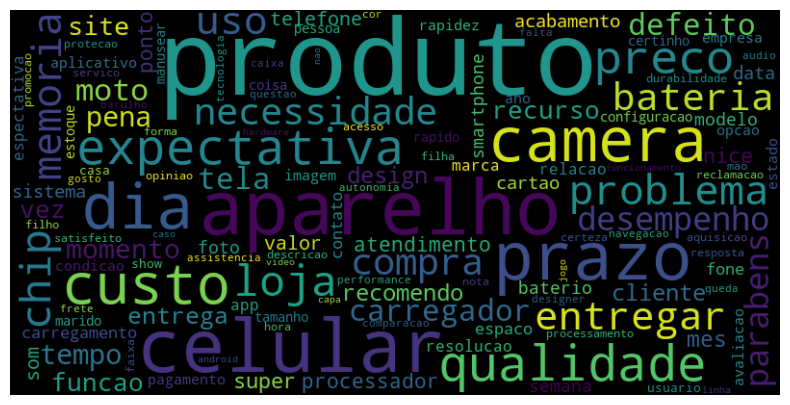

In [34]:
wordcloud_text = ' '.join(df["comments_topic"].astype(str))

wordcloud = WordCloud(width=800, height=400, random_state=15, max_font_size=110, max_words=130, collocations=False).generate(wordcloud_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [35]:
df_comments = df["comments_topic"]
doc_comments = df_comments.to_list()
doc_comments[:5]

['produto qualidade camera desenvolvimento rapidez',
 'produto funcao',
 'tempo prazo celular bateria dia',
 'produto design manusear',
 'tarde aparelho problema camera verdade camera produto']

In [36]:
%%time

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', low_memory=False)
hdbscan_model = HDBSCAN(min_samples=15, min_cluster_size=80, metric='euclidean', prediction_data=True)
topic_model = BERTopic(language="portuguese", calculate_probabilities=True, verbose=True, nr_topics="auto", top_n_words=10, min_topic_size=100, umap_model=umap_model, hdbscan_model=hdbscan_model)
topics, probs = topic_model.fit_transform(doc_comments)

2024-04-16 19:29:32,896 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

2024-04-16 19:29:42,560 - BERTopic - Embedding - Completed ✓
2024-04-16 19:29:42,561 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-16 19:29:46,804 - BERTopic - Dimensionality - Completed ✓
2024-04-16 19:29:46,806 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-16 19:29:46,871 - BERTopic - Cluster - Completed ✓
2024-04-16 19:29:46,872 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-16 19:29:46,903 - BERTopic - Representation - Completed ✓
2024-04-16 19:29:46,903 - BERTopic - Topic reduction - Reducing number of topics
2024-04-16 19:29:46,920 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3


CPU times: total: 36.8 s
Wall time: 14.3 s


In [37]:
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,0,513,0_produto_prazo_aparelho_dia,"[produto, prazo, aparelho, dia, expectativa, q...","[produto produto, produto, produto compra praz..."
1,1,156,1_camera_chip_aparelho_bateria,"[camera, chip, aparelho, bateria, memoria, cel...","[produto camera memoria, celular bateria camer..."
2,2,123,2_celular_custo_prazo_telefone,"[celular, custo, prazo, telefone, dia, smartph...","[celular, celular, celular]"


In [68]:
topic_model.get_topic(2)

[('celular', 0.40099702934911313),
 ('custo', 0.09345898634531351),
 ('prazo', 0.07740530468915634),
 ('telefone', 0.07648121794539235),
 ('dia', 0.06899769874153004),
 ('smartphone', 0.06329128447405481),
 ('momento', 0.06123526915083254),
 ('loja', 0.06088758529227197),
 ('preco', 0.05782506374240447),
 ('defeito', 0.057710839429058795)]

In [39]:
topic_model.visualize_barchart(top_n_topics=10)

In [40]:
df_topics = topic_model.get_document_info(doc_comments)
df_topics

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,produto qualidade camera desenvolvimento rapidez,1,1_camera_chip_aparelho_bateria,"[camera, chip, aparelho, bateria, memoria, cel...","[produto camera memoria, celular bateria camer...",camera - chip - aparelho - bateria - memoria -...,1.000000,False
1,produto funcao,0,0_produto_prazo_aparelho_dia,"[produto, prazo, aparelho, dia, expectativa, q...","[produto produto, produto, produto compra praz...",produto - prazo - aparelho - dia - expectativa...,0.371042,False
2,tempo prazo celular bateria dia,1,1_camera_chip_aparelho_bateria,"[camera, chip, aparelho, bateria, memoria, cel...","[produto camera memoria, celular bateria camer...",camera - chip - aparelho - bateria - memoria -...,0.677899,False
3,produto design manusear,0,0_produto_prazo_aparelho_dia,"[produto, prazo, aparelho, dia, expectativa, q...","[produto produto, produto, produto compra praz...",produto - prazo - aparelho - dia - expectativa...,0.594107,False
4,tarde aparelho problema camera verdade camera ...,1,1_camera_chip_aparelho_bateria,"[camera, chip, aparelho, bateria, memoria, cel...","[produto camera memoria, celular bateria camer...",camera - chip - aparelho - bateria - memoria -...,1.000000,False
...,...,...,...,...,...,...,...,...
787,qualidade acabamento tela servico balsa bicicl...,0,0_produto_prazo_aparelho_dia,"[produto, prazo, aparelho, dia, expectativa, q...","[produto produto, produto, produto compra praz...",produto - prazo - aparelho - dia - expectativa...,0.487728,False
788,celular nao avaliacao,2,2_celular_custo_prazo_telefone,"[celular, custo, prazo, telefone, dia, smartph...","[celular, celular, celular]",celular - custo - prazo - telefone - dia - sma...,1.000000,False
789,compra dia produto atendimento informacao loja...,0,0_produto_prazo_aparelho_dia,"[produto, prazo, aparelho, dia, expectativa, q...","[produto produto, produto, produto compra praz...",produto - prazo - aparelho - dia - expectativa...,0.553829,False
790,produto site,0,0_produto_prazo_aparelho_dia,"[produto, prazo, aparelho, dia, expectativa, q...","[produto produto, produto, produto compra praz...",produto - prazo - aparelho - dia - expectativa...,0.552134,False


In [41]:
df_info = df.copy()
df_info = df_info.drop(columns=['comments_topic'], axis=1, inplace=False)
df_info

,product_name,review_title,recommend_to_a_friend,comments,reviewer_birth_year,reviewer_gender,reviewer_state,comments_entity
0,Smartphone Motorola Moto G 5S Dual Chip Androi...,Gostei bastante do produto,Yes,Produto excelente qualidade boa câmera desenvo...,1987.0,M,GO,produto excelente qualidade boa camera desenvo...
1,Smartphone Motorola Moto G 5S Dual Chip Androi...,Muito show,Yes,"Produto excelente, ótimas funções, rápido, vis...",1989.0,M,CE,"produto excelente, otimas funcoes, rapido, vis..."
2,Smartphone Motorola Moto G 5S Dual Chip Androi...,"Muito bom, câmera ótima",Yes,"Nada mal, tempo de entrega antes do prazo. Sob...",1995.0,M,SP,"nada mal, tempo de entrega antes do prazo. sob..."
3,Smartphone Motorola Moto G 5S Dual Chip Androi...,Excelente!!!,Yes,"Excelente produto, belo design, fácil de manus...",1966.0,F,PR,"excelente produto, belo design, facil de manus..."
4,Smartphone Motorola Moto G 5S Dual Chip Androi...,Problema com o aparelho,No,"Boa tarde. Estou insatisfeita com o aparelho, ...",1995.0,F,SP,"boa tarde. estou insatisfeita com o aparelho, ..."
...,...,...,...,...,...,...,...,...
787,Smartphone Motorola Moto G 5S Dual Chip Androi...,"Otimo produto, pessimo vendedor.",Yes,"Se você quer um smartphone de ótima qualidade,...",1997.0,M,SP,"se voce quer um smartphone de otima qualidade,..."
788,Smartphone Motorola Moto G 5S Dual Chip Androi...,so avaliaçao da entrega porque o celular ainda...,No,"avaliar como se o celular ainda nao chegou ,av...",1975.0,F,SP,"avaliar como se o celular ainda nao chegou ,av..."
789,Smartphone Motorola Moto G 5S Dual Chip Androi...,Não recebi,No,Infelizmente avalio péssimo a compra! Já faz 3...,1987.0,F,SP,infelizmente avalio pessimo a compra! ja faz 3...
790,Smartphone Motorola Moto G 5S Dual Chip Androi...,Não tem como avaliar,No,Ainda não recebí o produto. E não consigo entr...,1980.0,M,MG,ainda nao recebi o produto. e nao consigo entr...


In [42]:
df_info["topic"] = df_topics["Topic"]

In [43]:
df_info

,product_name,review_title,recommend_to_a_friend,comments,reviewer_birth_year,reviewer_gender,reviewer_state,comments_entity,topic
0,Smartphone Motorola Moto G 5S Dual Chip Androi...,Gostei bastante do produto,Yes,Produto excelente qualidade boa câmera desenvo...,1987.0,M,GO,produto excelente qualidade boa camera desenvo...,1
1,Smartphone Motorola Moto G 5S Dual Chip Androi...,Muito show,Yes,"Produto excelente, ótimas funções, rápido, vis...",1989.0,M,CE,"produto excelente, otimas funcoes, rapido, vis...",0
2,Smartphone Motorola Moto G 5S Dual Chip Androi...,"Muito bom, câmera ótima",Yes,"Nada mal, tempo de entrega antes do prazo. Sob...",1995.0,M,SP,"nada mal, tempo de entrega antes do prazo. sob...",1
3,Smartphone Motorola Moto G 5S Dual Chip Androi...,Excelente!!!,Yes,"Excelente produto, belo design, fácil de manus...",1966.0,F,PR,"excelente produto, belo design, facil de manus...",0
4,Smartphone Motorola Moto G 5S Dual Chip Androi...,Problema com o aparelho,No,"Boa tarde. Estou insatisfeita com o aparelho, ...",1995.0,F,SP,"boa tarde. estou insatisfeita com o aparelho, ...",1
...,...,...,...,...,...,...,...,...,...
787,Smartphone Motorola Moto G 5S Dual Chip Androi...,"Otimo produto, pessimo vendedor.",Yes,"Se você quer um smartphone de ótima qualidade,...",1997.0,M,SP,"se voce quer um smartphone de otima qualidade,...",0
788,Smartphone Motorola Moto G 5S Dual Chip Androi...,so avaliaçao da entrega porque o celular ainda...,No,"avaliar como se o celular ainda nao chegou ,av...",1975.0,F,SP,"avaliar como se o celular ainda nao chegou ,av...",2
789,Smartphone Motorola Moto G 5S Dual Chip Androi...,Não recebi,No,Infelizmente avalio péssimo a compra! Já faz 3...,1987.0,F,SP,infelizmente avalio pessimo a compra! ja faz 3...,0
790,Smartphone Motorola Moto G 5S Dual Chip Androi...,Não tem como avaliar,No,Ainda não recebí o produto. E não consigo entr...,1980.0,M,MG,ainda nao recebi o produto. e nao consigo entr...,0


In [44]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
class_names = ['negative', 'neutral', 'positive']

class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [45]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin', map_location ='cpu'))
model = model.to(torch.device('cpu'))

In [46]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

def predict_sentiment(text):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to("cpu")
    attention_mask = encoded_review['attention_mask'].to("cpu")

    with torch.no_grad():
        output = model(input_ids, attention_mask)

    _, prediction = torch.max(output, dim=1)
    
    return class_names[prediction]

In [47]:
df_info["sentiment"] = df_info["comments"].apply(predict_sentiment)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [48]:
sentiment_counts = df_info.groupby(['topic', 'sentiment']).size().reset_index(name='count')

In [49]:
sentiment_counts

,topic,sentiment,count
0,0,negative,57
1,0,neutral,17
2,0,positive,439
3,1,negative,14
4,1,neutral,10
5,1,positive,132
6,2,negative,15
7,2,neutral,5
8,2,positive,103


In [50]:
sentiment_counts_filt = sentiment_counts.loc[sentiment_counts['topic'] == 4]
sentiment_counts_filt

,topic,sentiment,count


In [51]:
MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

tokenizer_ner = AutoTokenizer.from_pretrained("51la5/roberta-large-NER", model_max_length=512)
model_ner = XLMRobertaForTokenClassification.from_pretrained("51la5/roberta-large-NER")
ner_task = pipeline("ner", model=model_ner, tokenizer=tokenizer_ner)

Some weights of the model checkpoint at 51la5/roberta-large-NER were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
def extract_entities(df):
    all_entities = []

    for comment in df["comments_entity"]:
        predictions = ner_task(comment)
        comment_entities = []

        if predictions != []:
            combined_word = ""
            previous_entity = None

            for prediction in predictions:
                entity = prediction['entity']
                word = prediction['word']

                if not word.startswith('▁'):
                    combined_word += word
                else:
                    if combined_word:
                        comment_entities.append((combined_word, previous_entity))
                    combined_word = word

                previous_entity = entity

            if combined_word:
                comment_entities.append((combined_word, previous_entity))

        all_entities.append(comment_entities)

    df_copy = df.copy()
    df_copy["entity"] = all_entities

    return df_copy

In [53]:
df_ner = df_info.copy()
df_ner["entity"] = ""

In [54]:
df_ner = extract_entities(df_ner)

In [55]:
count_unique = df_ner['entity'].explode().value_counts()
count_unique

entity
(▁americanas, I-ORG)        43
(▁moto, I-MISC)             40
(▁motorola, I-ORG)          30
(▁motorola, I-MISC)         17
(▁g5s, I-MISC)              16
                            ..
(▁flip3, I-MISC)             1
(▁motorolalenovo, I-ORG)     1
(▁directlog, I-ORG)          1
(▁americanoscom, I-ORG)      1
(▁mericanacom, I-ORG)        1
Name: count, Length: 70, dtype: int64

In [73]:
def most_frequent_entity_per_topic(df):
    entity_per_topic = {'topic': [], 'entity_most_frequent': [], 'frequency_entity': []}

    groups = df.groupby('topic')

    for group_name, group_data in groups:
        entity_count = {}

        for index, row in group_data.iterrows():
            for entity_token in row['entity']:
                entity = entity_token[0]
                entity_count[entity] = entity_count.get(entity, 0) + 1

        most_frequent_entities = sorted(entity_count, key=entity_count.get, reverse=True)[:20]
        frequencies = [entity_count[entity] for entity in most_frequent_entities]

        entities_string = ', '.join(most_frequent_entities)
        frequencies_string = ', '.join(map(str, frequencies))

        entity_per_topic['topic'].append(group_name)
        entity_per_topic['entity_most_frequent'].append(entities_string)
        entity_per_topic['frequency_entity'].append(frequencies_string)

    df_most_frequent_entity = pd.DataFrame(entity_per_topic)

    return df_most_frequent_entity


In [74]:
df_entity_most_frequent = most_frequent_entity_per_topic(df_ner)
df_entity_most_frequent.head(10)

,topic,entity_most_frequent,frequency_entity
0,0,"▁americanas, ▁moto, ▁motorola, ▁g, ▁g5s, ▁amer...","37, 30, 26, 13, 11, 7, 7, 6, 6, 6, 6, 2, 2, 2,..."
1,1,"▁motorola, ▁moto, ▁g5s, ▁americanas, ▁g3, ▁and...","13, 7, 5, 4, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, ..."
2,2,"▁motorola, ▁moto, ▁google, ▁android, ▁asus, ▁a...","8, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1"


In [75]:
df_entity_most_frequent['entity_most_frequent'] = df_entity_most_frequent['entity_most_frequent'].str.replace('▁', '')

In [76]:
print(df_entity_most_frequent[['entity_most_frequent']].to_string(index=False))

                                                                                                                                          entity_most_frequent
                  americanas, moto, motorola, g, g5s, americana, 5s, americanascom, g5, lenovo, plus, samsung, lg, android, g2, 5, g4, s, motog, americaas.com
motorola, moto, g5s, americanas, g3, android, g4, asus, ios, google, sansung, gmail, lenovomotorola, motog5s, oreo, play, directlog, lenovo, k10, americas.com
                    motorola, moto, google, android, asus, americanas, 5s, g, samsung, americanas, motog, americanoscom, americanas.com, americanascom, g2., 5


In [77]:
print(df_entity_most_frequent[['frequency_entity']].to_string(index=False)) 

                                               frequency_entity
37, 30, 26, 13, 11, 7, 7, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 1
    13, 7, 5, 4, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1
                 8, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1


In [62]:
def show_reviews_by_sentiment_and_topic(df, topic):
    df_topic = df[df['topic'] == topic]

    for sentiment in ['positive', 'neutral', 'negative']:
        print(f"Reviews with sentiment '{sentiment}' in topic '{topic}':")
        
        df_sentiment = df_topic[df_topic['sentiment'] == sentiment]
        
        for i, review_text in enumerate(df_sentiment['comments'].head(5)):
            print(f"{i}. {review_text}")
        print()

In [63]:
df_ner

,product_name,review_title,recommend_to_a_friend,comments,reviewer_birth_year,reviewer_gender,reviewer_state,comments_entity,topic,sentiment,entity
0,Smartphone Motorola Moto G 5S Dual Chip Androi...,Gostei bastante do produto,Yes,Produto excelente qualidade boa câmera desenvo...,1987.0,M,GO,produto excelente qualidade boa camera desenvo...,1,positive,"[(▁android, I-MISC)]"
1,Smartphone Motorola Moto G 5S Dual Chip Androi...,Muito show,Yes,"Produto excelente, ótimas funções, rápido, vis...",1989.0,M,CE,"produto excelente, otimas funcoes, rapido, vis...",0,positive,[]
2,Smartphone Motorola Moto G 5S Dual Chip Androi...,"Muito bom, câmera ótima",Yes,"Nada mal, tempo de entrega antes do prazo. Sob...",1995.0,M,SP,"nada mal, tempo de entrega antes do prazo. sob...",1,positive,[]
3,Smartphone Motorola Moto G 5S Dual Chip Androi...,Excelente!!!,Yes,"Excelente produto, belo design, fácil de manus...",1966.0,F,PR,"excelente produto, belo design, facil de manus...",0,positive,[]
4,Smartphone Motorola Moto G 5S Dual Chip Androi...,Problema com o aparelho,No,"Boa tarde. Estou insatisfeita com o aparelho, ...",1995.0,F,SP,"boa tarde. estou insatisfeita com o aparelho, ...",1,negative,[]
...,...,...,...,...,...,...,...,...,...,...,...
787,Smartphone Motorola Moto G 5S Dual Chip Androi...,"Otimo produto, pessimo vendedor.",Yes,"Se você quer um smartphone de ótima qualidade,...",1997.0,M,SP,"se voce quer um smartphone de otima qualidade,...",0,positive,[]
788,Smartphone Motorola Moto G 5S Dual Chip Androi...,so avaliaçao da entrega porque o celular ainda...,No,"avaliar como se o celular ainda nao chegou ,av...",1975.0,F,SP,"avaliar como se o celular ainda nao chegou ,av...",2,negative,[]
789,Smartphone Motorola Moto G 5S Dual Chip Androi...,Não recebi,No,Infelizmente avalio péssimo a compra! Já faz 3...,1987.0,F,SP,infelizmente avalio pessimo a compra! ja faz 3...,0,negative,[]
790,Smartphone Motorola Moto G 5S Dual Chip Androi...,Não tem como avaliar,No,Ainda não recebí o produto. E não consigo entr...,1980.0,M,MG,ainda nao recebi o produto. e nao consigo entr...,0,negative,"[(▁americanas, I-ORG)]"


In [80]:
show_reviews_by_sentiment_and_topic(df_ner, 2)

Reviews with sentiment 'positive' in topic '2':
0. Gostei do pedido e prazo de entrega. Celular muito bom para o preço pago, ótima promoção
1. O celular é excelente! Vale cada centavo! Os outros são caros, neste celular não pagamos pela grife, mas em momento algum o torna inferior.
2. Nada a reclamar sobre o celular, é muito bom. apesar de a entrega ter sido feita antes do prazo,entrou em rota dia 14, isso estava na cidade vizinha que não demoraria para chegar, foi chegar na minha casa dia 16. não entendo pq demorou tanto em rota.
3. Tudo perfeito, um excelente smartfone é um ótimo custo beneficio!
4. Ainda não vi pontos negativos. Me surpreendi, não esperava que fosse um celular tão bom. Pelo custo benefício vale muito a pena.

Reviews with sentiment 'neutral' in topic '2':
0. Gostei do produto, porém, esquenta de mais, e acredito q o fone ou não era pra esse modelo ou tá com defeito pq não encaixa no celular corretamente, quando mexe no plug do fone as vezes funciona e outras vezes n